In [1]:
from google.colab import drive,output
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/datasets/optic_disc/archive.zip -d archive
output.clear()

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,Reshape,LeakyReLU,UpSampling2D,MaxPooling2D,concatenate,Input,Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
!pip install git+https://github.com/tensorflow/examples.git
!pip install segmentation_models

output.clear()


In [4]:
!export SM_FRAMEWORK=tf.keras
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [5]:
img_h=224
img_w=224

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))#,cmap='gray')
    plt.axis('off')
  plt.show()

In [7]:
import glob
import cv2
import os
images_t = glob.glob("archive/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set/*.jpg")
images_t.sort()
images_v = glob.glob("archive/A.%20Segmentation/A. Segmentation/1. Original Images/b. Testing Set/*.jpg")
images_v.sort()
masks_t = glob.glob("archive/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/5. Optic Disc/*.tif")
masks_t.sort()
masks_v = glob.glob("archive/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/5. Optic Disc/*.tif")
masks_v.sort()
print(len(images_t))
print(len(images_v))
print(len(masks_t))
print(len(masks_v))

54
27
54
27


In [8]:
train_data=np.zeros((len(images_t),img_h,img_w,3),dtype=np.uint8)
test_data=np.zeros((len(images_v),img_h,img_w,3),dtype=np.uint8)
train_mask=np.zeros((len(images_t),img_h,img_w,1),dtype=bool)
test_mask=np.zeros((len(images_v),img_h,img_w,1),dtype=bool)

In [9]:
for n,id in tqdm(enumerate(images_t),total=len(images_t)):
  img=load_img(id,target_size=(224,224),color_mode='grayscale')
  img=img_to_array(img)
  train_data[n]=img

  img=load_img(masks_t[n],target_size=(224,224),color_mode='grayscale')
  img=img_to_array(img)
  train_mask[n]=img

for n,id in tqdm(enumerate(images_v),total=len(images_v)):
  img=load_img(id,target_size=(224,224),color_mode='grayscale')
  img=img_to_array(img)
  test_data[n]=img

  img=load_img(masks_v[n],target_size=(224,224),color_mode='grayscale')
  img=img_to_array(img)
  test_mask[n]=img

100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


In [10]:
print(train_data.shape)
print(train_mask.shape)
print(test_data.shape)
print(test_mask.shape)

(54, 224, 224, 3)
(54, 224, 224, 1)
(27, 224, 224, 3)
(27, 224, 224, 1)


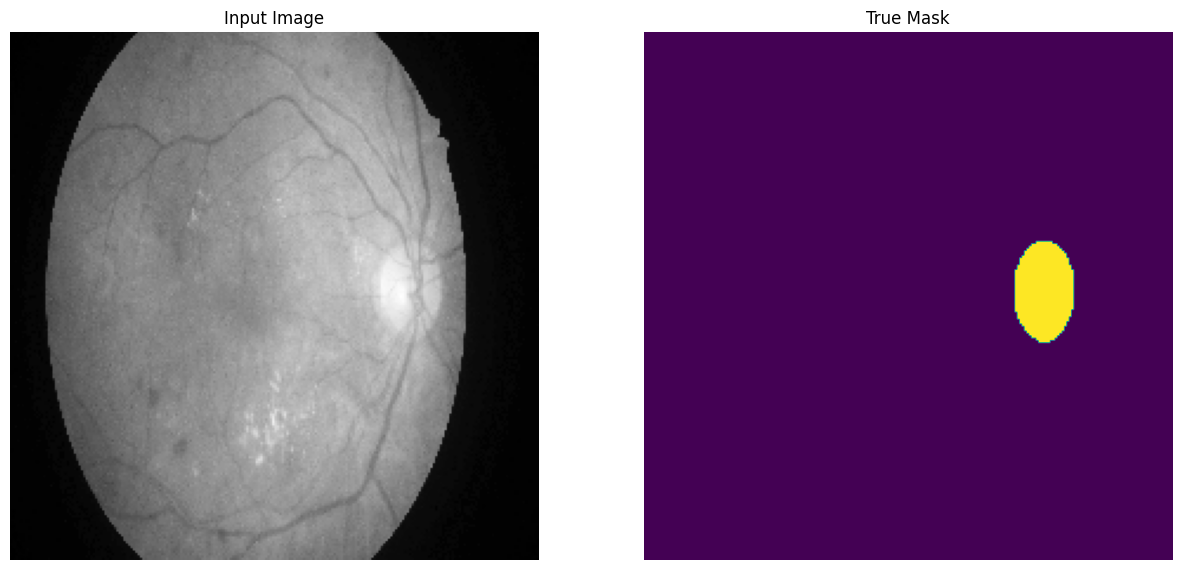

In [12]:
display([train_data[0],train_mask[0]])

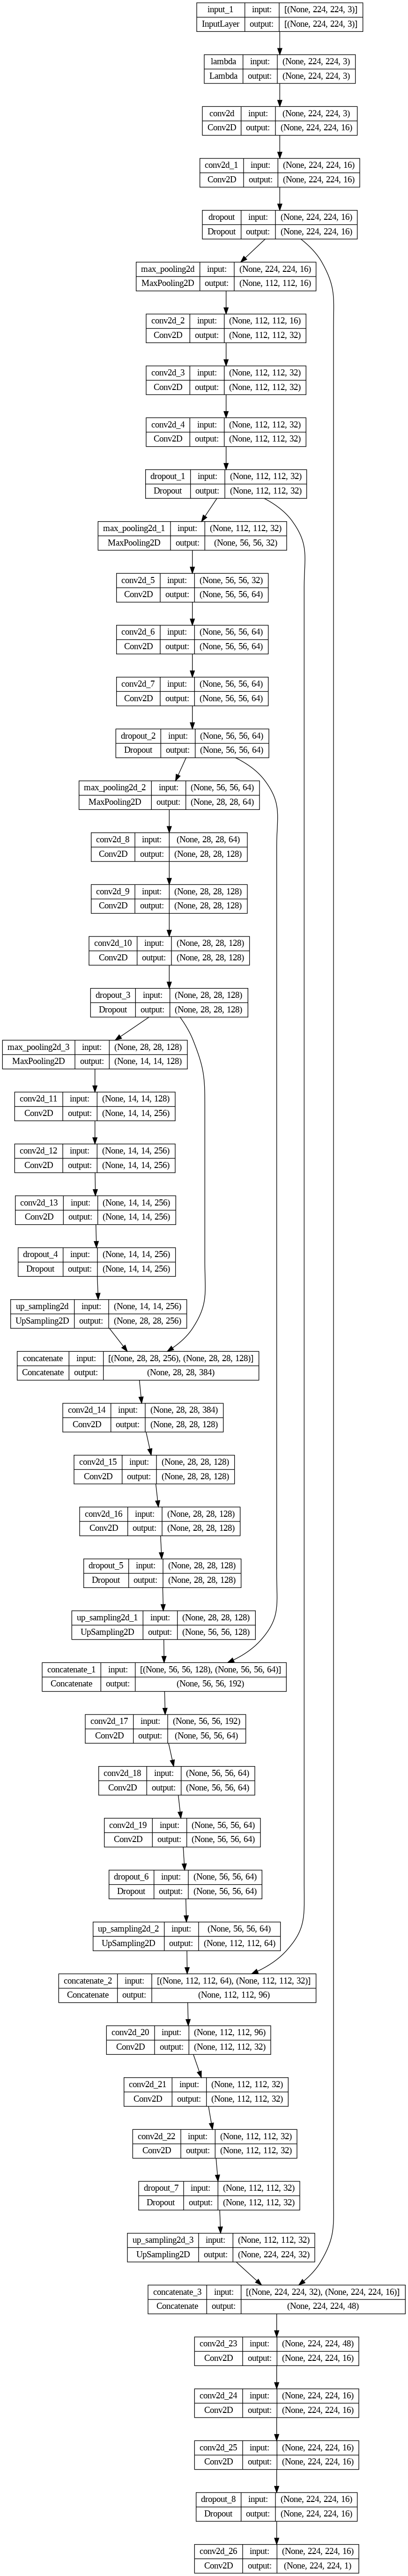

In [13]:
inputs=Input((img_h,img_w,3))
s=Lambda(lambda x:x/255)(inputs)
c1=Conv2D(16,3,padding='same',activation='relu')(s)
c1=Conv2D(16,3,padding='same',activation='relu')(c1)
c1=Dropout(0.2)(c1)
    #downsample
p1=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c1)

c2=Conv2D(32,3,padding='same',activation='relu')(p1)
c2=Conv2D(32,3,padding='same',activation='relu')(c2)
c2=Conv2D(32,3,padding='same',activation='relu')(c2)
c2=Dropout(0.2)(c2)
    #downsample
p2=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c2)

c3=Conv2D(64,3,padding='same',activation='relu')(p2)
c3=Conv2D(64,3,padding='same',activation='relu')(c3)
c3=Conv2D(64,3,padding='same',activation='relu')(c3)
c3=Dropout(0.2)(c3)
    #downsample
p3=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c3)

c4=Conv2D(128,3,padding='same',activation='relu')(p3)
c4=Conv2D(128,3,padding='same',activation='relu')(c4)
c4=Conv2D(128,3,padding='same',activation='relu')(c4)
c4=Dropout(0.2)(c4)
    #downsample
p4=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c4)

c5=Conv2D(256,3,padding='same',activation='relu')(p4)
c5=Conv2D(256,3,padding='same',activation='relu')(c5)
c5=Conv2D(256,3,padding='same',activation='relu')(c5)
c5=Dropout(0.2)(c5)

    #upsample
u6=UpSampling2D()(c5)
u6=concatenate([u6,c4])
c6=Conv2D(128,3,padding='same',activation='relu')(u6)
c6=Conv2D(128,3,padding='same',activation='relu')(c6)
c6=Conv2D(128,3,padding='same',activation='relu')(c6)
c6=Dropout(0.2)(c6)

u7=UpSampling2D()(c6)
u7=concatenate([u7,c3])
c7=Conv2D(64,3,padding='same',activation='relu')(u7)
c7=Conv2D(64,3,padding='same',activation='relu')(c7)
c7=Conv2D(64,3,padding='same',activation='relu')(c7)
c7=Dropout(0.2)(c7)

u8=UpSampling2D()(c7)
u8=concatenate([u8,c2])
c8=Conv2D(32,3,padding='same',activation='relu')(u8)
c8=Conv2D(32,3,padding='same',activation='relu')(c8)
c8=Conv2D(32,3,padding='same',activation='relu')(c8)
c8=Dropout(0.2)(c8)

u9=UpSampling2D()(c8)
u9=concatenate([u9,c1])
c9=Conv2D(16,3,padding='same',activation='relu')(u9)
c9=Conv2D(16,3,padding='same',activation='relu')(c9)
c9=Conv2D(16,3,padding='same',activation='relu')(c9)
c9=Dropout(0.2)(c9)

outputs=Conv2D(1,(1,1),activation='sigmoid')(c9)
    # Flatten(),
    # Dense(1,activation='softmax')

model=Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss='binary_crossentropy',metrics=['accuracy'])

# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
mp=ModelCheckpoint('best_seg model.h5',save_best_only=True,monitor='val_accuracy')
call=[mp]

model.fit(
    train_data,
    train_mask,
    validation_data=(test_data,test_mask),
    batch_size=1,
    # steps_per_epoch=100,
    epochs=10,
    callbacks=call
)

Epoch 1/10
54/54 [==============================] - 1s 23ms/step - loss: 0.0133 - accuracy: 0.9943 - val_loss: 0.0163 - val_accuracy: 0.9927
Epoch 2/10
54/54 [==============================] - 1s 21ms/step - loss: 0.0108 - accuracy: 0.9952 - val_loss: 0.0149 - val_accuracy: 0.9936
Epoch 3/10
54/54 [==============================] - 1s 17ms/step - loss: 0.0114 - accuracy: 0.9950 - val_loss: 0.0278 - val_accuracy: 0.9911
Epoch 4/10
54/54 [==============================] - 1s 21ms/step - loss: 0.0106 - accuracy: 0.9950 - val_loss: 0.0136 - val_accuracy: 0.9943
Epoch 5/10
54/54 [==============================] - 1s 22ms/step - loss: 0.0105 - accuracy: 0.9953 - val_loss: 0.0130 - val_accuracy: 0.9949
Epoch 6/10
54/54 [==============================] - 1s 18ms/step - loss: 0.0126 - accuracy: 0.9945 - val_loss: 0.0222 - val_accuracy: 0.9910
Epoch 7/10
54/54 [==============================] - 1s 21ms/step - loss: 0.0091 - accuracy: 0.9958 - val_loss: 0.0128 - val_accuracy: 0.9949
Epoch 8/10
54

In [19]:
for i in range(len(test_data)):
  p=test_data[i]
  p=p.reshape(( 1,p.shape[0], p.shape[1], p.shape[2]))
  pred=model.predict(p)
  # pred=XX
  print(pred.shape)
  pred=pred.reshape((pred.shape[1],pred.shape[2],pred.shape[3]))
  display([test_data[i],test_mask[i],pred])

Output hidden; open in https://colab.research.google.com to view.

In [22]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb4'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, input_shape=(img_h,img_w,3),encoder_weights='imagenet',activation='sigmoid')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics = ['binary_accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.IOUScore(),sm.metrics.FScore()])# tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
mp=ModelCheckpoint('best_seg model.h5',save_best_only=True,monitor='val_accuracy')
call=[mp]

model.fit(
    train_data,
    train_mask,
    validation_data=(test_data,test_mask),
    batch_size=1,
    # steps_per_epoch=100,
    epochs=10,
    callbacks=call
)

Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 0.5799 - binary_accuracy: 0.7746 - recall_1: 0.8381 - precision_1: 0.0637 - auc_1: 0.8737 - iou_score: 0.0307 - f1-score: 0.0595

54/54 [==============================] - 92s 200ms/step - loss: 0.5799 - binary_accuracy: 0.7746 - recall_1: 0.8381 - precision_1: 0.0637 - auc_1: 0.8737 - iou_score: 0.0307 - f1-score: 0.0595 - val_loss: 1.8329 - val_binary_accuracy: 0.4046 - val_recall_1: 0.9991 - val_precision_1: 0.0282 - val_auc_1: 0.9541 - val_iou_score: 0.0264 - val_f1-score: 0.0514
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 0.3740 - binary_accuracy: 0.9824 - recall_1: 0.9465 - precision_1: 0.5062 - auc_1: 0.9887 - iou_score: 0.0495 - f1-score: 0.0942

54/54 [==============================] - 5s 87ms/step - loss: 0.3740 - binary_accuracy: 0.9824 - recall_1: 0.9465 - precision_1: 0.5062 - auc_1: 0.9887 - iou_score: 0.0495 - f1-score: 0.0942 - val_loss: 0.7136 - val_binary_accuracy: 0.7824 - val_recall_1: 0.9986 - val_precision_1: 0.0735 - val_auc_1: 0.9907 - val_iou_score: 0.0428 - val_f1-score: 0.0819
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 0.2673 - binary_accuracy: 0.9965 - recall_1: 0.9447 - precision_1: 0.8738 - auc_1: 0.9958 - iou_score: 0.0649 - f1-score: 0.1218

54/54 [==============================] - 6s 103ms/step - loss: 0.2673 - binary_accuracy: 0.9965 - recall_1: 0.9447 - precision_1: 0.8738 - auc_1: 0.9958 - iou_score: 0.0649 - f1-score: 0.1218 - val_loss: 0.3177 - val_binary_accuracy: 0.9637 - val_recall_1: 0.9932 - val_precision_1: 0.3216 - val_auc_1: 0.9974 - val_iou_score: 0.0652 - val_f1-score: 0.1222
Epoch 4/10
54/54 [==============================] - ETA: 0s - loss: 0.2071 - binary_accuracy: 0.9975 - recall_1: 0.9493 - precision_1: 0.9153 - auc_1: 0.9986 - iou_score: 0.0804 - f1-score: 0.1487

54/54 [==============================] - 5s 94ms/step - loss: 0.2071 - binary_accuracy: 0.9975 - recall_1: 0.9493 - precision_1: 0.9153 - auc_1: 0.9986 - iou_score: 0.0804 - f1-score: 0.1487 - val_loss: 0.2205 - val_binary_accuracy: 0.9895 - val_recall_1: 0.9860 - val_precision_1: 0.6241 - val_auc_1: 0.9972 - val_iou_score: 0.0812 - val_f1-score: 0.1499
Epoch 5/10
54/54 [==============================] - ETA: 0s - loss: 0.1666 - binary_accuracy: 0.9978 - recall_1: 0.9440 - precision_1: 0.9349 - auc_1: 0.9981 - iou_score: 0.0964 - f1-score: 0.1755

54/54 [==============================] - 5s 87ms/step - loss: 0.1666 - binary_accuracy: 0.9978 - recall_1: 0.9440 - precision_1: 0.9349 - auc_1: 0.9981 - iou_score: 0.0964 - f1-score: 0.1755 - val_loss: 0.1706 - val_binary_accuracy: 0.9938 - val_recall_1: 0.9806 - val_precision_1: 0.7417 - val_auc_1: 0.9980 - val_iou_score: 0.0980 - val_f1-score: 0.1782
Epoch 6/10
54/54 [==============================] - ETA: 0s - loss: 0.1368 - binary_accuracy: 0.9980 - recall_1: 0.9497 - precision_1: 0.9379 - auc_1: 0.9987 - iou_score: 0.1145 - f1-score: 0.2051

54/54 [==============================] - 6s 108ms/step - loss: 0.1368 - binary_accuracy: 0.9980 - recall_1: 0.9497 - precision_1: 0.9379 - auc_1: 0.9987 - iou_score: 0.1145 - f1-score: 0.2051 - val_loss: 0.1304 - val_binary_accuracy: 0.9964 - val_recall_1: 0.9395 - val_precision_1: 0.8641 - val_auc_1: 0.9935 - val_iou_score: 0.1158 - val_f1-score: 0.2069
Epoch 7/10
54/54 [==============================] - ETA: 0s - loss: 0.1139 - binary_accuracy: 0.9980 - recall_1: 0.9508 - precision_1: 0.9375 - auc_1: 0.9989 - iou_score: 0.1335 - f1-score: 0.2351

54/54 [==============================] - 5s 90ms/step - loss: 0.1139 - binary_accuracy: 0.9980 - recall_1: 0.9508 - precision_1: 0.9375 - auc_1: 0.9989 - iou_score: 0.1335 - f1-score: 0.2351 - val_loss: 0.1100 - val_binary_accuracy: 0.9960 - val_recall_1: 0.9562 - val_precision_1: 0.8357 - val_auc_1: 0.9985 - val_iou_score: 0.1360 - val_f1-score: 0.2386
Epoch 8/10
54/54 [==============================] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.9983 - recall_1: 0.9563 - precision_1: 0.9472 - auc_1: 0.9994 - iou_score: 0.1542 - f1-score: 0.2665

54/54 [==============================] - 5s 88ms/step - loss: 0.0961 - binary_accuracy: 0.9983 - recall_1: 0.9563 - precision_1: 0.9472 - auc_1: 0.9994 - iou_score: 0.1542 - f1-score: 0.2665 - val_loss: 0.0952 - val_binary_accuracy: 0.9972 - val_recall_1: 0.9319 - val_precision_1: 0.9066 - val_auc_1: 0.9978 - val_iou_score: 0.1481 - val_f1-score: 0.2571
Epoch 9/10
54/54 [==============================] - ETA: 0s - loss: 0.0823 - binary_accuracy: 0.9983 - recall_1: 0.9580 - precision_1: 0.9485 - auc_1: 0.9995 - iou_score: 0.1749 - f1-score: 0.2971

54/54 [==============================] - 6s 108ms/step - loss: 0.0823 - binary_accuracy: 0.9983 - recall_1: 0.9580 - precision_1: 0.9485 - auc_1: 0.9995 - iou_score: 0.1749 - f1-score: 0.2971 - val_loss: 0.0840 - val_binary_accuracy: 0.9970 - val_recall_1: 0.9124 - val_precision_1: 0.9113 - val_auc_1: 0.9961 - val_iou_score: 0.1625 - val_f1-score: 0.2783
Epoch 10/10
54/54 [==============================] - ETA: 0s - loss: 0.0706 - binary_accuracy: 0.9987 - recall_1: 0.9679 - precision_1: 0.9612 - auc_1: 0.9997 - iou_score: 0.1984 - f1-score: 0.3303

54/54 [==============================] - 5s 88ms/step - loss: 0.0706 - binary_accuracy: 0.9987 - recall_1: 0.9679 - precision_1: 0.9612 - auc_1: 0.9997 - iou_score: 0.1984 - f1-score: 0.3303 - val_loss: 0.0739 - val_binary_accuracy: 0.9970 - val_recall_1: 0.9065 - val_precision_1: 0.9189 - val_auc_1: 0.9930 - val_iou_score: 0.1802 - val_f1-score: 0.3039


In [24]:
for i in range(len(test_data)):
  p=test_data[i]
  p=p.reshape(( 1,p.shape[0], p.shape[1], p.shape[2]))
  pred=model.predict(p)
  # pred=XX
  print(pred.shape)
  pred=pred.reshape((pred.shape[1],pred.shape[2],pred.shape[3]))
  display([test_data[i],test_mask[i],pred])

Output hidden; open in https://colab.research.google.com to view.